In [1]:
# Data manipulation and math computation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing

# Data visualisation 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import networkx as nx 
%matplotlib inline

# For statistical analysis
from scipy import stats

# Searchign for Outliers
from sklearn.ensemble import IsolationForest

# Metrics used for measuring the accuracy and performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

# ML algorithms for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# ML algorithms for the classification
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

/Users/rostyslav/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the data

In [2]:
# Initial train dataset to be used as a baseline
pure_train_df = pd.read_csv("train.csv",sep=",")
# features and labels
pure_train_y = pure_train_df['Choice']
pure_train_x = pure_train_df.drop(columns=['Choice'])
print(pure_train_df.shape)
pure_train_df.head()

(5500, 23)


,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [3]:
# dataset after the graph analysis
network_train_df = pd.read_csv('PartitionedNetwork.csv',sep=",")
# Setup indexing
network_train_df.index = network_train_df['Unnamed: 0']
network_train_df.index.name = ''
# and drop the corresponding column
network_train_df.drop(columns=['Unnamed: 0'],inplace=True)
# features and labels
network_train_y = network_train_df['Choice']
network_train_x = network_train_df.drop(columns=['Choice'])
print(network_train_df.shape)
network_train_df.head()

(5319, 37)


,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
0,34,0,40,190,228,302,3,0.583979,0.100503,0.100503,...,0,1,1,0,0,0,0,1,0,0
1,33,1,39,113,21591,1179,228,90.456506,25.798292,5.709329,...,2,2,1,0,0,0,1,0,0,0
2,3,2,1,788,7310,1215,101,25.503644,9.556347,5.361519,...,3,3,0,0,1,0,0,0,1,0
3,39,3,38,99,20,7,2,7.690824,0.277306,1.331508,...,4,4,1,0,0,0,1,0,0,0
4,37,4,42,307,45589,862,2641,148.854279,36.998884,27.881768,...,4,4,1,0,0,0,1,0,0,0


# Define the models

## Functions to evaluate

In [30]:
# Function to evaluate the results using Accuracy and ROC AUC
def evaluate(model,x_test,y_true):
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    #Accuracy score 
    accuracy = accuracy_score(y_pred=predictions,y_true=y_true)
    print("\nAccuracy: {:.3f}% ".format(accuracy*100))
    # ROC AUC score
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y_true)
    print("ROC AUC: {:.3f}% \n".format(roc_auc*100))  

# Run cross-validation
def run_cross_validation(model,x_tot,y_tot,cv):
    print('Starting Cross-validation')
    
    #Score using accuracy
    scoresAccuracy=cross_val_score(model,x_tot,y_tot,cv=cv,verbose=1)
    print("CV with accuracy: %0.3f +/- %0.3f" % (scoresAccuracy.mean(), scoresAccuracy.std()))
    
    #Score with AUC
    scoresROCAUC=cross_val_score(model,x_tot,y_tot,cv=cv,scoring='roc_auc',verbose=1)
    print("CV with ROC AUC: %0.3f +/- %0.3f" % (scoresROCAUC.mean(), scoresROCAUC.std()))
    
    #Plot learning curve 
    plot_learning_curve(model,name,x_tot,y_tot,cv=cv,n_jobs=-1)
    plt.show()
    
def advanced_evaluate_model(model,name, x_train, y_train, x_test, y_test, cv):
    # Train the algorithm
    history = model.fit(x_train,y_train)
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    print(model)
    # Evaluate the results
    evaluate(model,x_test,y_test) 
    
    # Merge test and train samples
    x_tot = pd.concat([x_train,x_test],axis=0)
    y_tot = pd.concat([y_train,y_test],axis=0)

    # If run cross-validation:
    if cv:
        #Cross-validation

        # Splitting strategy
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    
        run_cross_validation(model,x_tot,y_tot,cv=kfold)
    
    # ROC Curve. 
    fpr,tpr,thresh = roc_curve(y_test,predicting_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr,tpr,label = ("Area under the curve {:0.3f}".format(auc(fpr,tpr))),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title(name + " ROC - Curve & Area Under Curve",fontsize=18)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    # plot learning history:
    if name == 'DNN': 
        plot_DNN_training_history(history)
        plt.show()
    
    print('\n\n')
    
    model.fit(x_tot,y_tot)
    
    return model

# function to evaluate the feature importance
def feature_importance(df_ini,model,model_type,model_name):
    # transform the input data, accessing is different for different algorithms, hard coded now. 
    # Should be imporved later
    if model_type == 'importance':
        df = pd.DataFrame(model.feature_importances_,df_ini.columns).reset_index()
    else:
        df = pd.DataFrame(model.coef_.ravel(),df_ini.columns).reset_index()
    df.rename(columns={'index':'features',0:'coefficients'},inplace=True)
    # sort the values
    df.sort_values(by='coefficients',ascending = False,inplace=True)
        
    #plot
    sns.barplot(x = df['coefficients'] ,y = df['features'])    
    plt.title("Feature Importance " + model_name,fontsize=11,fontweight="bold")
    
def fast_feature_importance(df,models):
    df_x = df
    if 'Choice' in df.columns:
        df_x = df.drop(columns=['Choice'])
    # Analyse feature importance
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)
    for i, model in enumerate(models,start=1):
        plt.subplot(2,2,i)
        feature_importance(df_x,model.model,model.model_type,model.name)

## ML models

In [24]:
class MLmodel:
    def __init__(self,model,name,model_type = 'importance'):
        self.name = name
        self.model = model
        self.model_type = model_type

In [25]:
models = [
    XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.01,max_depth=3),
    LogisticRegression(penalty='l1',class_weight='balanced', random_state=1),
    RandomForestClassifier(n_estimators=100,random_state=1,max_depth=3,min_samples_leaf=10),
]

MLmodels = [
    MLmodel(models[0],'XGBoost','importance'),
    MLmodel(models[1],'LogisticRegression','coef'),
    MLmodel(models[2],'RandomForest','importance')
]

# Baseline

## Pure dataset

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 76.273% 
ROC AUC: 86.069% 



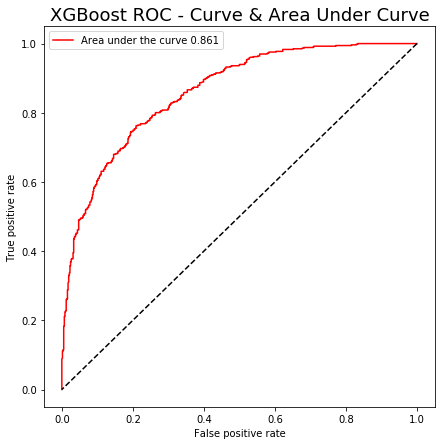




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 71.364% 
ROC AUC: 77.278% 



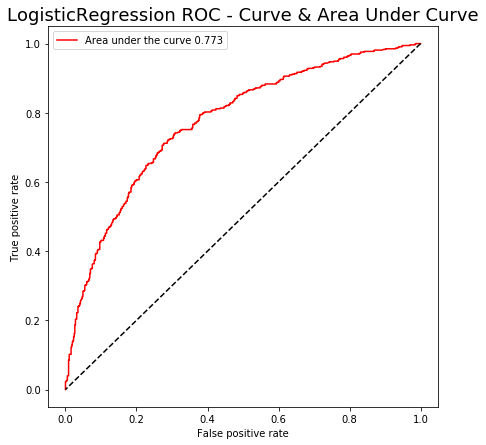




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 74.636% 
ROC AUC: 84.083% 



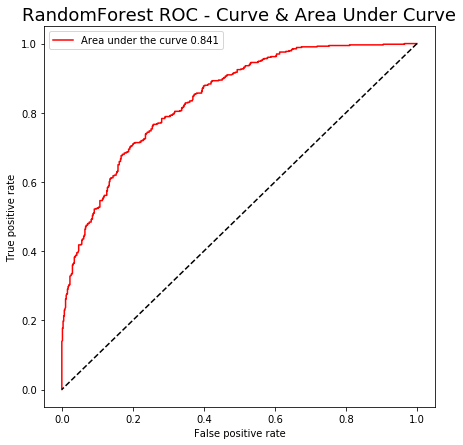

In [26]:
model_res = {}
x_train, x_test, y_train, y_test = train_test_split(pure_train_x, pure_train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

## Network dataset 

* First run with all the columns, just to test

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 78.289% 
ROC AUC: 87.679% 



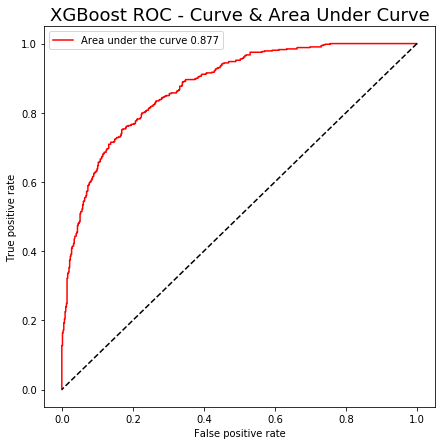




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 72.932% 
ROC AUC: 79.203% 



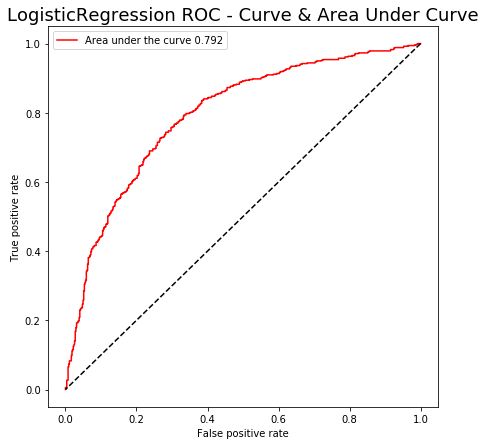




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 76.786% 
ROC AUC: 86.180% 



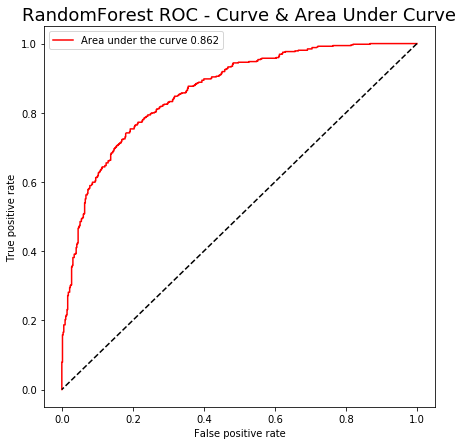

In [28]:
x_train, x_test, y_train, y_test = train_test_split(network_train_x, network_train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

XGBoost
LogisticRegression
RandomForest


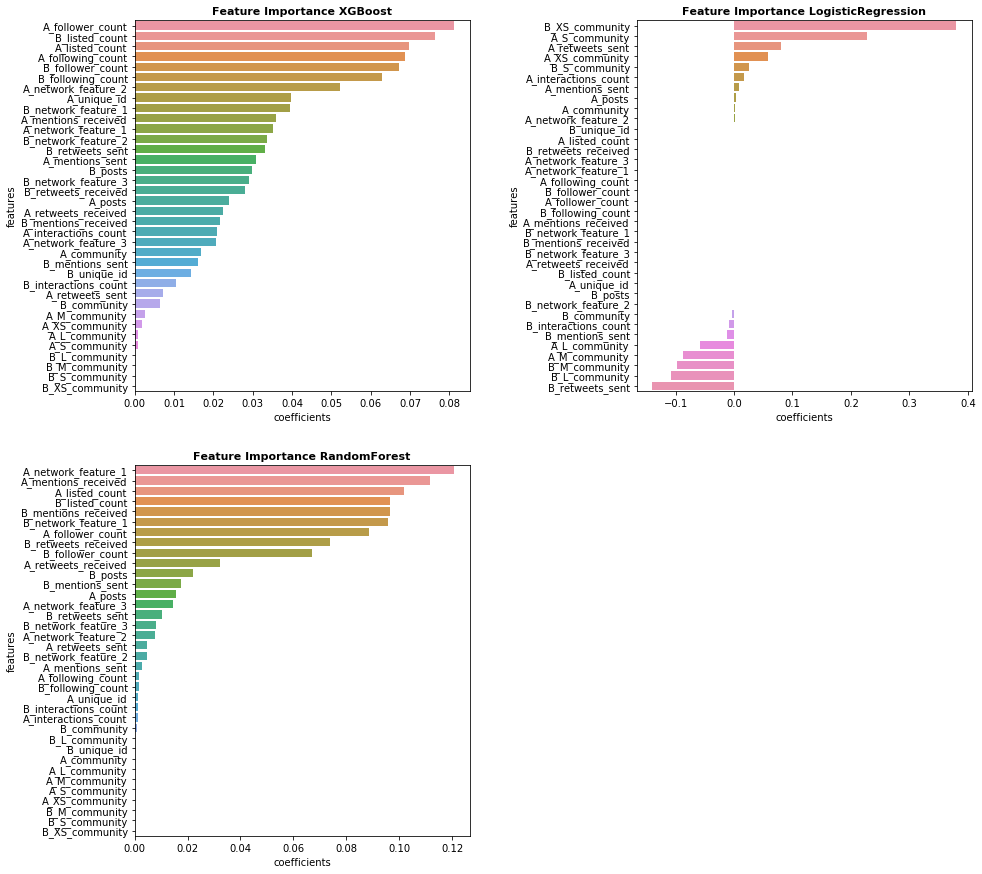

In [29]:
fast_feature_importance(network_train_x,MLmodels)

* Improvement of 1.5% for the XGBoost and 2% for the RF
* Drop some columns

In [44]:
network_train_reduced_x = network_train_x.drop(columns=['B_unique_id','A_unique_id'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 77.820% 
ROC AUC: 87.708% 



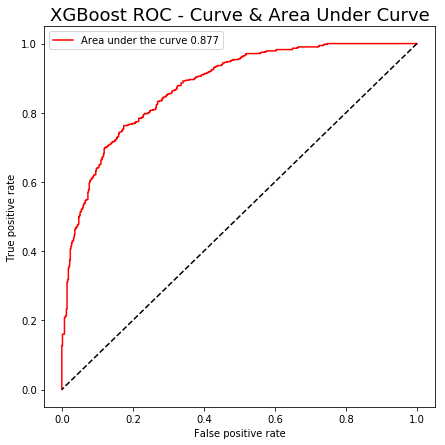




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 72.932% 
ROC AUC: 79.107% 



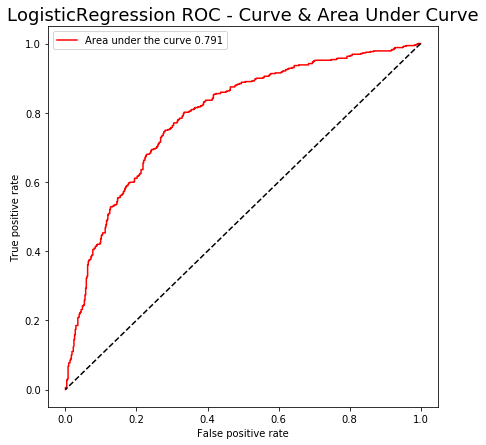




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 76.692% 
ROC AUC: 86.055% 



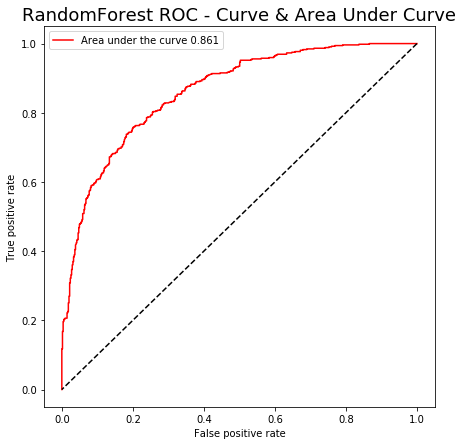

In [45]:
x_train, x_test, y_train, y_test = train_test_split(network_train_reduced_x, network_train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

# Train models for communities

In [66]:
#sanity check:
msum = 0
network_train_comm_df = dict()
network_train_comm_y = dict()
network_train_comm_x = dict()
for s in ['L','M','S','XS','nL']:
    if s == 'nL':
        network_train_comm_df[s] = network_train_df.query('A_L_community != 1 or B_L_community != 1')
    else:
        msum += network_train_x.query('A_' + s + '_community == 1 and B_' + s + '_community == 1').shape[0]
        network_train_comm_df[s] = network_train_df.query('A_' + s + '_community == 1 and B_' + s + '_community == 1')
    network_train_comm_y[s] = network_train_comm_df[s]['Choice']
    network_train_comm_x[s] = network_train_comm_df[s].drop(columns=['Choice'])
    print('Size of community ' + s + ': ' + str(network_train_comm_x[s].shape[0]))
msum

Size of community L: 4105
Size of community M: 206
Size of community S: 232
Size of community XS: 252
Size of community nL: 1214


4795

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 80.390% 
ROC AUC: 89.896% 



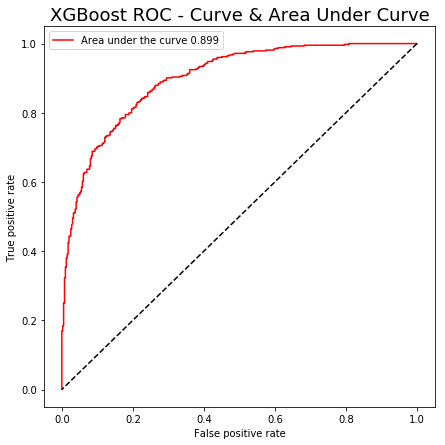




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 76.370% 
ROC AUC: 83.066% 



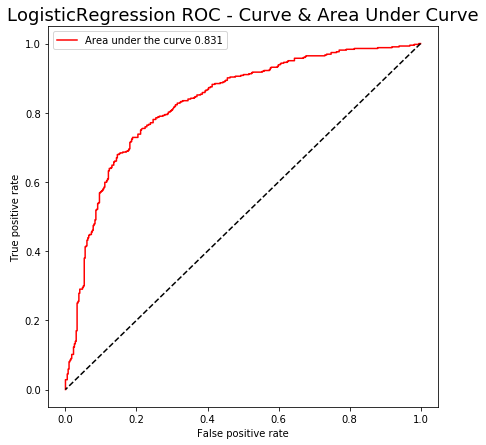




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 79.294% 
ROC AUC: 88.374% 



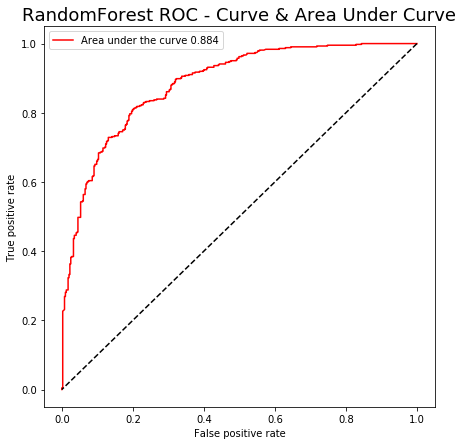

In [53]:
x_train, x_test, y_train, y_test = train_test_split(network_train_comm_x['L'], network_train_comm_y['L'], test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

In [71]:
network_train_comm_x['M'].head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
20,1,18,5,344,352126,499,4428,476.925046,201.199206,6.710281,...,7,7,0,1,0,0,0,1,0,0
28,39,23,39,245,57840,27137,5245,271.759860,35.955804,13.079388,...,1,1,0,1,0,0,0,1,0,0
109,4,90,6,477,1424824,338,6096,462.507299,135.304122,0.334766,...,7,7,0,1,0,0,0,1,0,0
149,10,116,39,281,725,645,44,4.108299,0.709693,1.568909,...,1,1,0,1,0,0,0,1,0,0
156,4,121,6,383,6375552,813,13024,12873.600932,4515.515176,1.035210,...,7,7,0,1,0,0,0,1,0,0


In [89]:
network_train_comm_red_x = network_train_comm_x['M'].drop(columns=['B_XS_community','A_XS_community','A_S_community','B_S_community','A_M_community','B_M_community','A_L_community','B_L_community','A_community','B_community'])

In [96]:
network_train_comm_red_x.shape

(206, 26)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 59.524% 
ROC AUC: 64.691% 



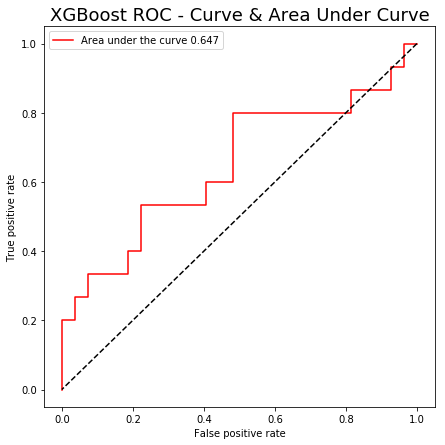




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 40.476% 
ROC AUC: 43.210% 



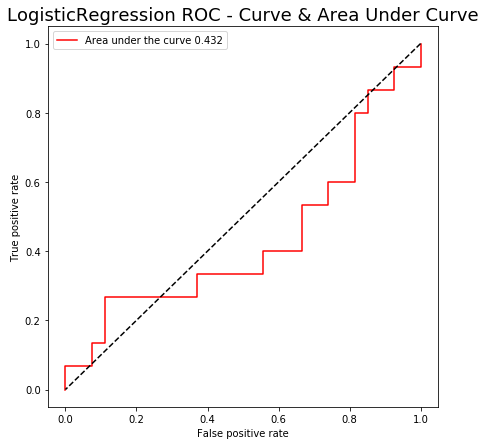




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 61.905% 
ROC AUC: 63.951% 



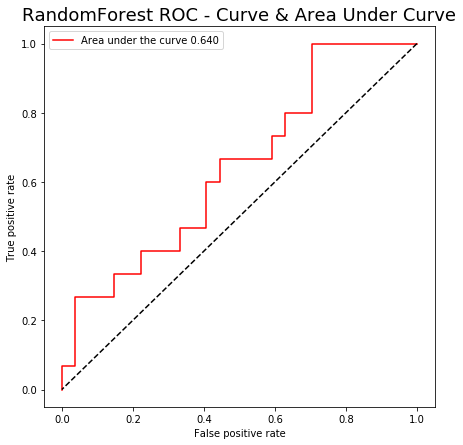

In [92]:
models = [
    XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.01,max_depth=3),
    LogisticRegression(penalty='l1',class_weight='balanced', random_state=1),
    RandomForestClassifier(n_estimators=100,random_state=1,max_depth=3,min_samples_leaf=10),
]

MLmodels = [
    MLmodel(models[0],'XGBoost','importance'),
    MLmodel(models[1],'LogisticRegression','coef'),
    MLmodel(models[2],'RandomForest','importance')
]

x_train, x_test, y_train, y_test = train_test_split(network_train_comm_red_x, network_train_comm_y['M'], test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

* very-very bad performance. Try to do some feature engineering here

In [101]:
train_x = network_train_comm_x['M'].drop(columns=['B_XS_community','A_XS_community','A_S_community','B_S_community','A_M_community','B_M_community','A_L_community','B_L_community','A_community','B_community','A_unique_id','B_unique_id'])
train_y = network_train_comm_y['M']
train_x.head()

,B_interactions_count,A_interactions_count,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
,,,,,,,,,,,,,,,,,,,,,
20,1,5,352126,499,4428,476.925046,201.199206,6.710281,0.100503,7.974549,...,136440,243073,33169.806819,6627.822210,0.100503,0.100503,0.100503,54819,17.676085,2006.176049
28,39,39,57840,27137,5245,271.759860,35.955804,13.079388,0.100503,12.642881,...,154157,1590,299.607879,80.190286,0.100503,0.100503,0.100503,791,122.252802,11514.811955
109,4,6,1424824,338,6096,462.507299,135.304122,0.334766,0.334766,0.334766,...,24,41017,410.052993,36.803759,0.100503,0.100503,0.100503,1716,21.034662,1734.612941
149,10,39,725,645,44,4.108299,0.709693,1.568909,0.834706,1.832665,...,201,7,0.351840,0.100503,0.351840,0.100503,0.351840,1,29.000000,469.000000
156,4,6,6375552,813,13024,12873.600932,4515.515176,1.035210,0.100503,2.039037,...,147,98965,1892.914388,678.010954,0.842497,0.100503,0.842497,7979,37.135769,2639.140829


In [103]:
# Create a bunch of "A-B" and "A/B" features
minus_features = ['follower_count']
ratio_features = ['interactions_count']
for col in minus_features:
    train_x['AmB_' + col] = train_x['A_'+col] - train_x['B_'+col]
    
for cand in ['A','B']:
    train_x[cand + '_follower_m_following_count'] = train_x[cand + '_follower_count'] - train_x[cand + '_following_count']
    train_x[cand + '_received_m_send_mentions'] = train_x[cand + '_mentions_received'] - train_x[cand + '_mentions_sent']
    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 66.667% 
ROC AUC: 74.568% 



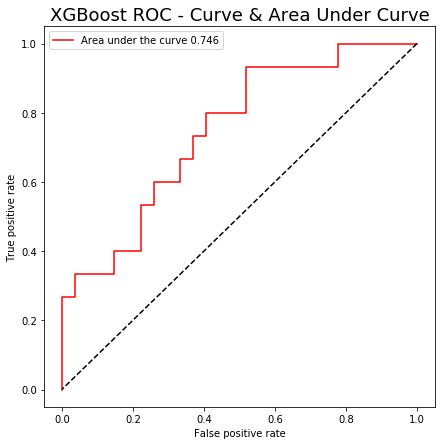




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 42.857% 
ROC AUC: 43.457% 



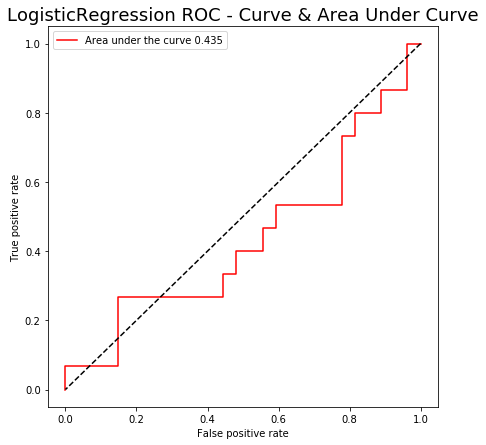




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 57.143% 
ROC AUC: 62.963% 



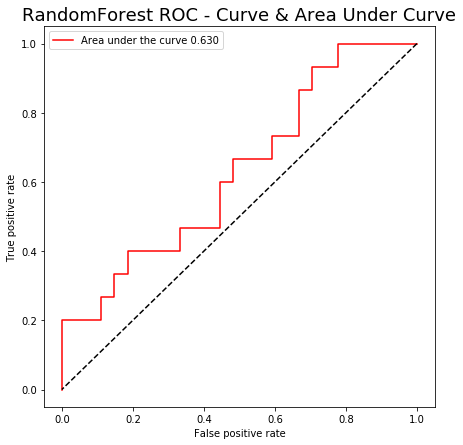

In [109]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)